# Increasing Access to Physical Therapy

In [1]:
import pandas as pd
import ptmaps
from pysal.esda import mapclassify as mc

## US population data

In [2]:
usdat = ptmaps.loadUSdata(prefix="../ch15683_pt_access_maps/")

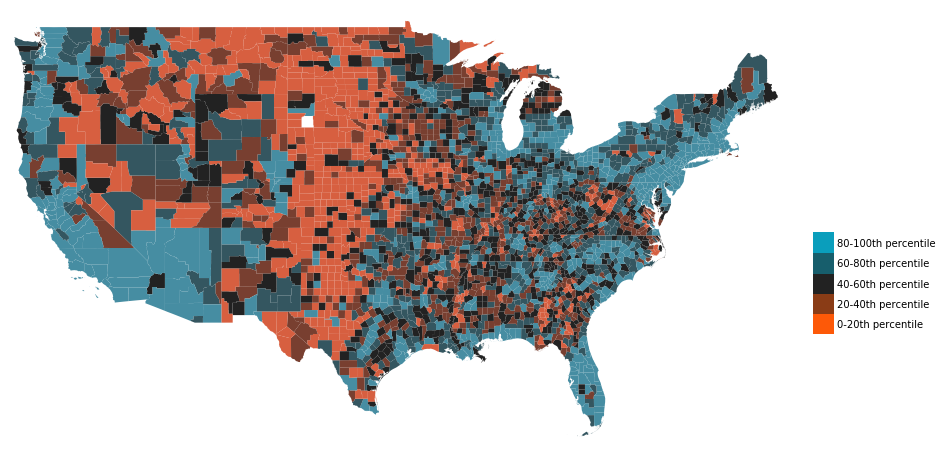

In [3]:
ptmaps.draw_choropleth(usdat, 'population', mincol=20, maxcol=220, nquantiles=5)

Figure 1: Just to warm up, this is the US population by county.  The Census Bureau estimates do not contain any data for the Oglala Lakota Reservation in Wyoming.

In [4]:
usdat.loc[pd.isnull(usdat['population']), :]

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,respop72012,respop72013,respop72014,respop72015,respop72016,population,popdens,area,statepop,statearea
2667,46,102,01266992,0500000US46102,46102,Oglala Lakota,06,5422847813,7126221,"POLYGON ((-103.001068 43.605799, -102.999045 4...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,851039.0,73717.12


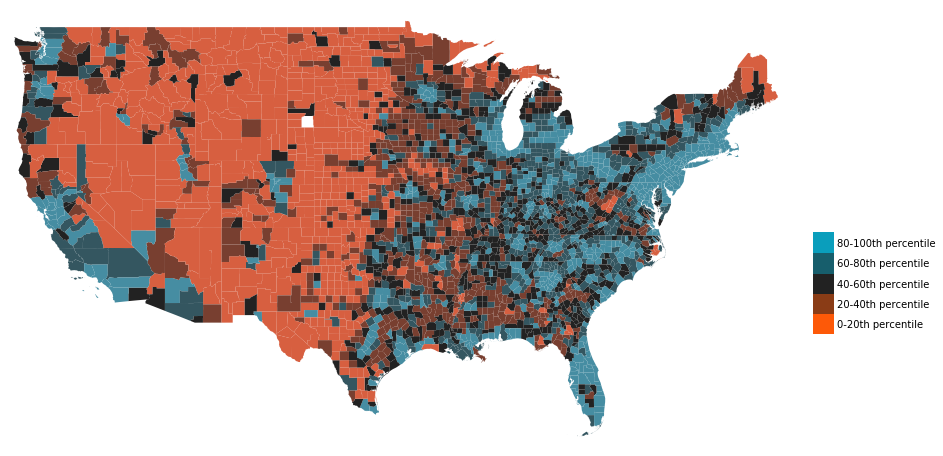

In [5]:
ptmaps.draw_choropleth(usdat, 'popdens', mincol=20, maxcol=220, nquantiles=5)

Figure 2.  This is the US population density by county. The Oglala Lakota reservation is missing data here again. 

In [6]:
usdat['smoothpopdens'] = ptmaps.genSmoothedPopDens(usdat, .001)

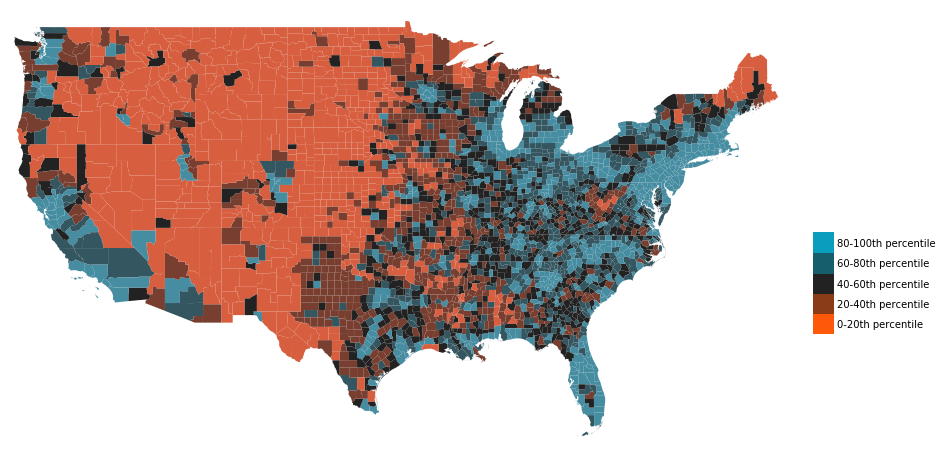

In [7]:
ptmaps.draw_choropleth(usdat, 'smoothpopdens', mincol=20, maxcol=220, nquantiles=5)

Figure 3. Enter smoothing.  This is the US population density by county with some state level smooth.  The estimated population density for each county shown in this plot is a sort of weighted average of the observed population density for the county, and the overall population density of the state.  In the missing data situations, this weighted average will produce exactly the state-level population density.  The weight given to the  state level density is 1000th that of the observed county-level density, so the smoothing effect is very minor.

## CMS Physical Therapy Data

In [8]:
ptdat = ptmaps.foldInPTdata(usdat, prefix='../ch15683_pt_access_maps/')

/usr/local/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [9]:
import pandas as pd
ptdat['population'][pd.isnull(ptdat.npts)].sum() + ptdat['population'][ptdat.npts < 10].sum()

20645647.0

20M people in counties with fewer than 10 PTs. 

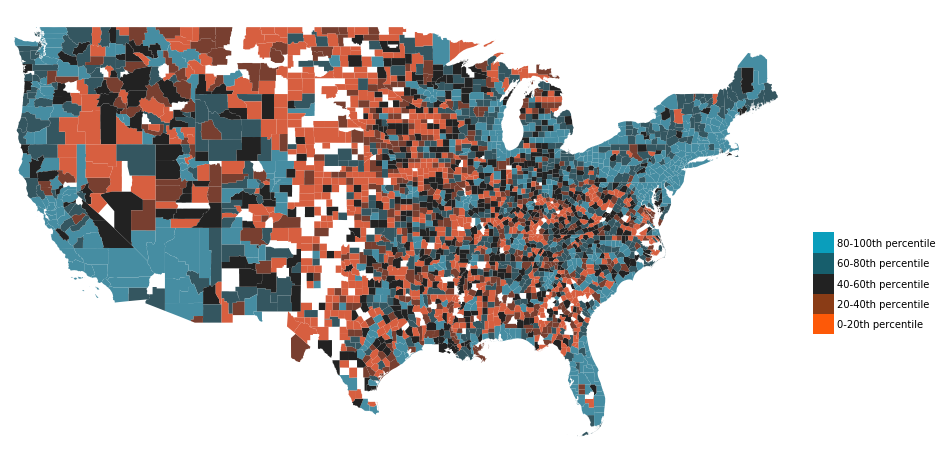

In [10]:
ptmaps.draw_choropleth(ptdat, 'npts', mincol=20, maxcol=220, nquantiles=5, fname='nptraw.png')

Figure 4.  The number of physical therapists by county.  Here it is evident that for many counties our PT data indicated no physical therapists.  This might mean there are actually 0 physical therapists with practice addresses in these counties.  But maybe they are just missing from our data.  So rather than represent them as 0s, we will regard them as missing data and employ a smoothing technique similar to above.  

In [11]:
ptdat['nptssmooth'] = ptmaps.genSmoothedNPTS(ptdat, shrinkagefactor=0.001)

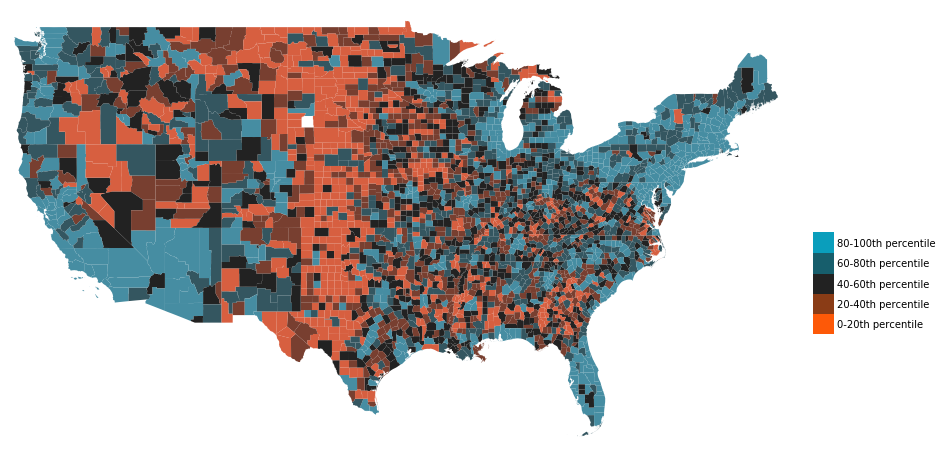

In [12]:
ptmaps.draw_choropleth(ptdat, 'nptssmooth', mincol=20, maxcol=220, nquantiles=5, fname='nptsmooth.png')

Figure 5.  The number of physical therapists by county with some smoothing.  In this case, we derive a smoothed estimate of the number of physical therapists per capita, where this ratio will be shrunk towards the overall state level ratio of physical therapists per capita.  This will be a fraction between 0 and 1.  To produce a smoothed estimate of the number of PTs per county, we multiply the census bureau estimate of the population of the county against the smoothed estimate of PTs per capita.  Note that here again the Oglala Lakota county is missing data, since there is no Census Bureau population estimate to use.  

In [13]:
ptcols = ['#E8E8E8', '#C7D9DE', '#A6CAD3', '#85BBC9', '#64ACBE']

In [14]:
nptq = mc.Quantiles(ptdat.loc[pd.notnull(ptdat['nptssmooth']),['nptssmooth']], k=5)
nptq

                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    3.424               622
   3.424 < x[i] <=    7.318               621
   7.318 < x[i] <=   15.382               621
  15.382 < x[i] <=   45.676               621
  45.676 < x[i] <= 3759.365               622

In [15]:
ptdat['nptssmoothq'] = ptdat['nptssmooth'].apply(lambda x: nptq.find_bin(x))

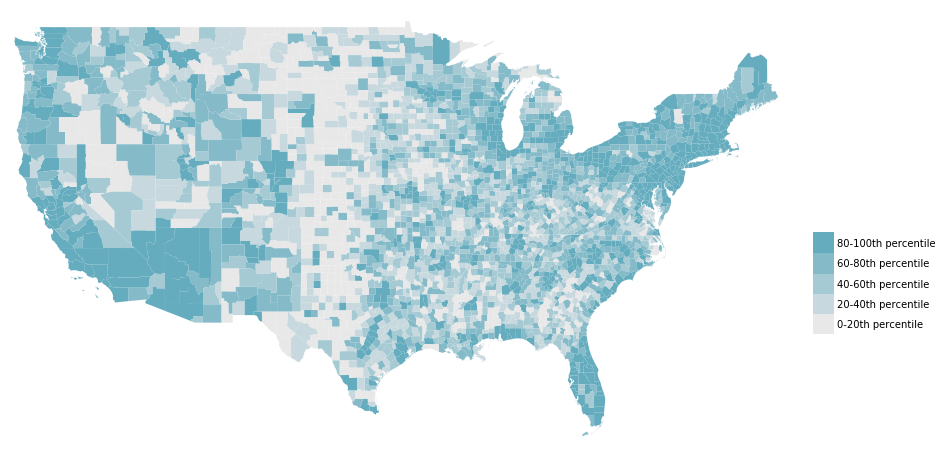

In [16]:
ptmaps.draw_choropleth2(ptdat, 'nptssmoothq', ptcols, fname='nptsmooth1col.png')

Figure 5 in one color.

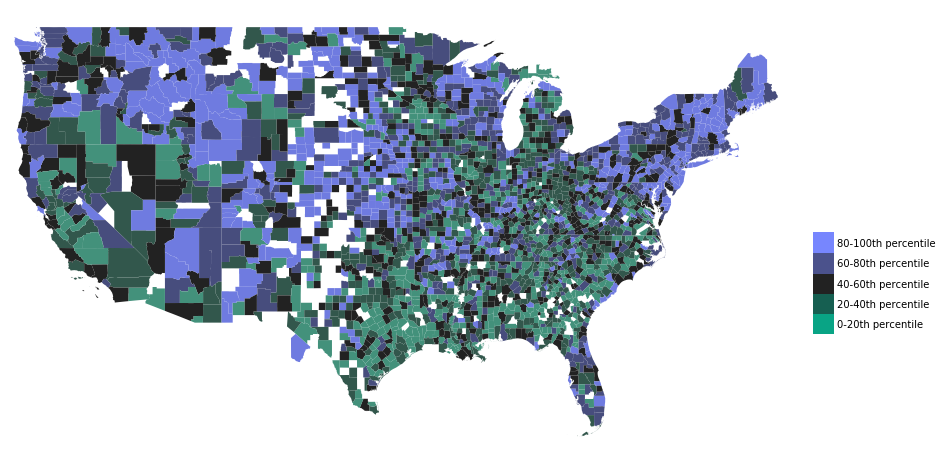

In [17]:
ptmaps.draw_choropleth(ptdat, 'ptp1k', maxcol=263, nquantiles=5, fname='ptp1kraw.png')

Figure 6.  This shows the number of physical therapists per 1000 residents per county.  Again, we will explicitly represent missing data and employ smoothing to fill in the gaps. 

In [18]:
ptdat['ptp1ksmooth'] = ptmaps.genSmoothedPTP1K(ptdat, shrinkagefactor=0.001)

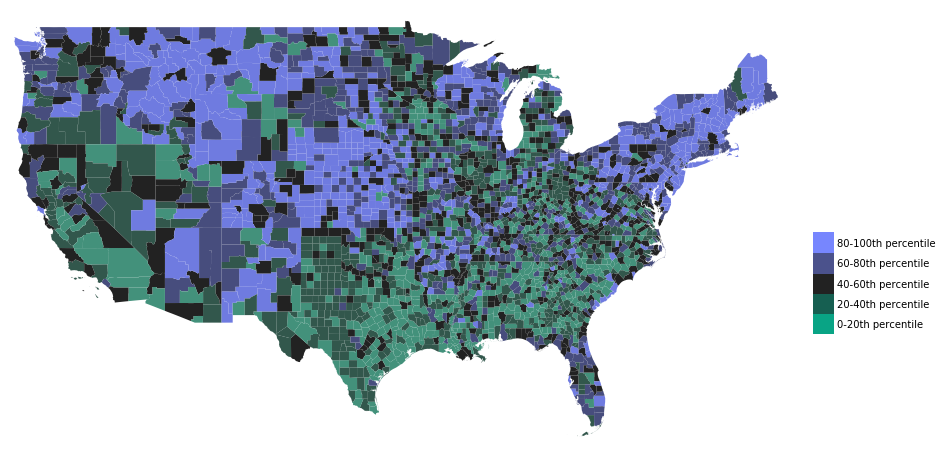

In [19]:
ptmaps.draw_choropleth(ptdat, 'ptp1ksmooth', maxcol=263, nquantiles=5, fname='ptp1ksmooth.png')

Figure 7.  The smoothed estimates of physical therapists per 1000 residents.  

In [20]:
currentq = mc.Quantiles(ptdat['ptp1ksmooth'], k=5)
currentq

               Quantiles               
 
Lower          Upper              Count
        x[i] <= 0.299               622
0.299 < x[i] <= 0.381               621
0.381 < x[i] <= 0.498               622
0.498 < x[i] <= 0.656               621
0.656 < x[i] <= 2.164               622

In [21]:
ptdat['ptp1ksmoothq'] = ptdat['ptp1ksmooth'].apply(lambda x: currentq.find_bin(x))

In [22]:
ptdat['population'][ptdat['ptp1ksmoothq'] == 4].sum()/ptdat['population'].sum()

0.22351969322419155

In [23]:
1000/.656

1524.390243902439

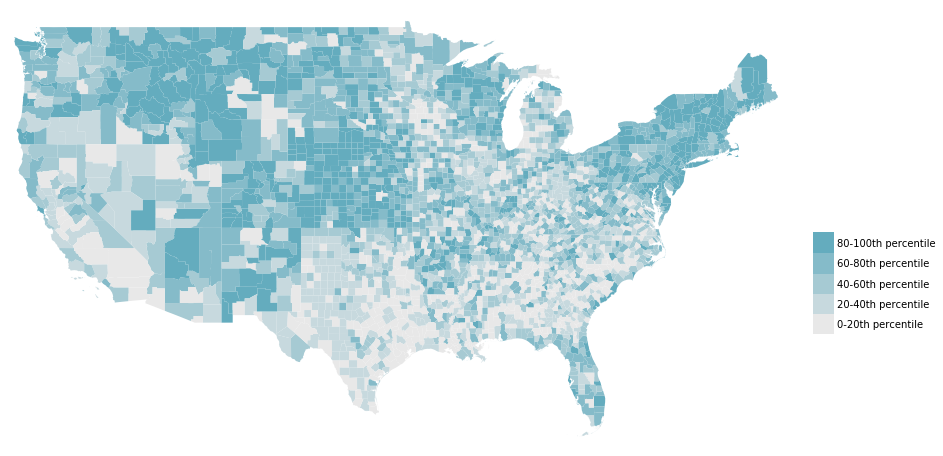

In [24]:
ptmaps.draw_choropleth2(ptdat, 'ptp1ksmoothq', ptcols, fname='ptp1ksmooth1col.png')

Figure 7 in one color. 

In [25]:
shrinkagefactor = 0.001
ptdat['ptp1kp10smooth'] = [
    1000 * 
    (10 + (x.npts if (pd.notnull(x.npts) and pd.notnull(x.population)) else 0) + shrinkagefactor * x.statepts) / 
    ((x.population if (pd.notnull(x.npts) and pd.notnull(x.population)) else 0) + shrinkagefactor * x.statepop)
    for ii, x in ptdat.iterrows()
]
ptdat['ptp1kp10smoothq'] = ptdat['ptp1kp10smooth'].apply(lambda x: currentq.find_bin(x))

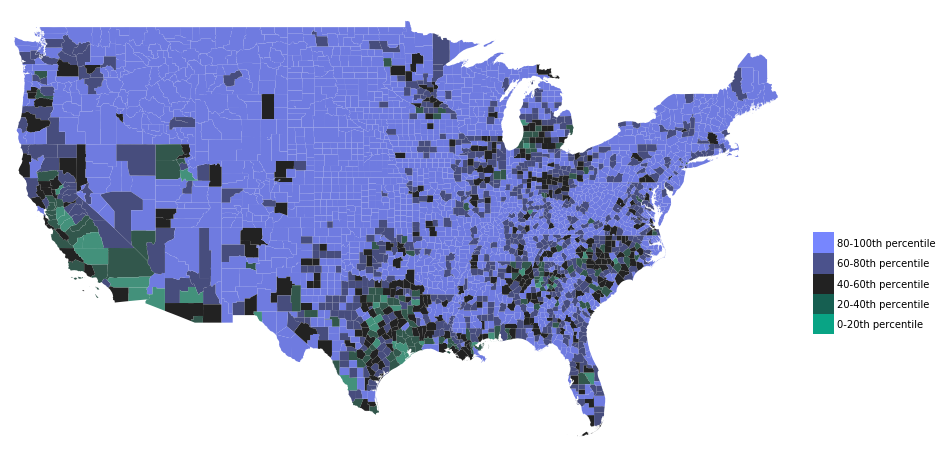

In [26]:
ptmaps.draw_choropleth(ptdat, 'ptp1kp10smoothq', nquantiles=5, maxcol=263, scheme=None, fname='ptp1kp10smooth.png')

Figure 8.  Physical therapists per 1000 residents With 10 additional PTs per county.  

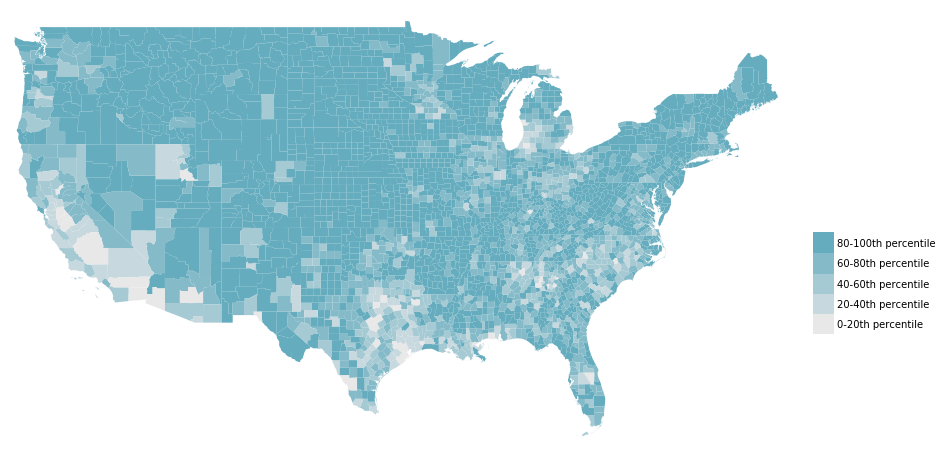

In [27]:
ptmaps.draw_choropleth2(ptdat, 'ptp1kp10smoothq', ptcols, fname='ptp1kp10smooth1col.png')

Figure 8 in one color. 

In [28]:
shrinkagefactor = 0.001
ptdat['ptp1kp100smooth'] = [
    1000 * 
    (100 + (x.npts if (pd.notnull(x.npts) and pd.notnull(x.population)) else 0) + shrinkagefactor * x.statepts) / 
    ((x.population if (pd.notnull(x.npts) and pd.notnull(x.population)) else 0) + shrinkagefactor * x.statepop)
    for ii, x in ptdat.iterrows()
]
ptdat['ptp1kp100smoothq'] = ptdat['ptp1kp100smooth'].apply(lambda x: currentq.find_bin(x))

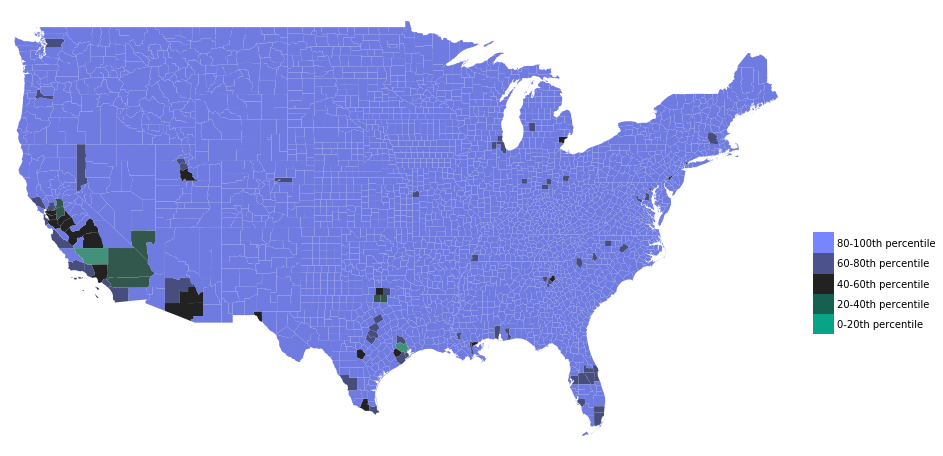

In [29]:
ptmaps.draw_choropleth(ptdat, 'ptp1kp100smoothq', nquantiles=5, maxcol=263, scheme=None)

Figure 9.  Physical therapists per 1000 residents With 100 additional PTs per county.  

In [30]:
ptq = mc.Quantiles(ptdat['ptp1ksmooth'], k=3)
ptdat['ptp1ksmoothq'] = ptdat['ptp1ksmooth'].apply(lambda x: ptq.find_bin(x))
popq = mc.Quantiles(ptdat['population'], k=3)
ptdat['populationq'] = ptdat['population'].apply(lambda x: popq.find_bin(x))
popdensq = mc.Quantiles(ptdat['smoothpopdens'], k=3)
ptdat['popdensq'] = ptdat['smoothpopdens'].apply(lambda x: popdensq.find_bin(x))

ptdat['bivcode'] = [3*x.ptp1ksmoothq + x.popdensq for ii, x in ptdat.iterrows()]

/usr/local/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/usr/local/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [31]:
bivariatemap = ['#e8e8e8', '#e4acac', '#c85a5a', '#b0d5df', '#ad9ea5', '#985356', '#64acbe', '#627f8c', '#574249']


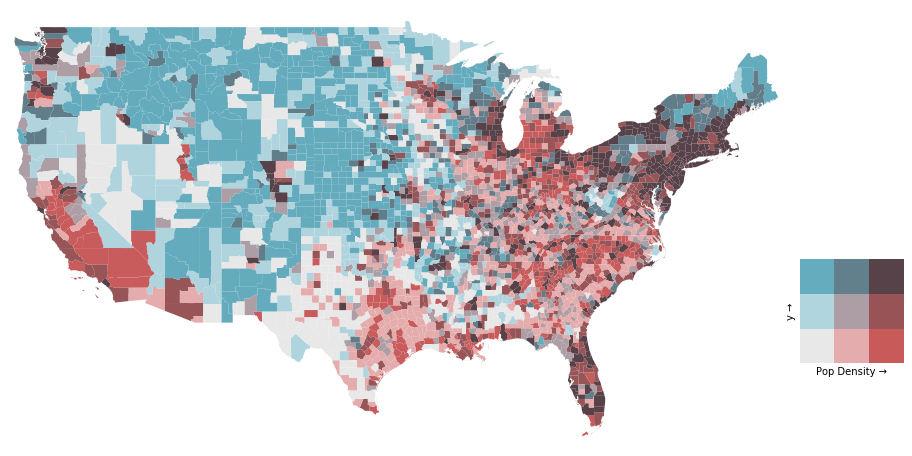

In [32]:
ptmaps.draw_choropleth2(ptdat, 'bivcode', bivariatemap, isbivariate=True, xlabel='Pop Density', fname='ptaccessvspopdens.png')

Figure 10.  PT access rate vs population density emphasizes locales with high population density and low PT access. 